<h2><center><u>Hypothesis Testing</u></center></h2>
<h1><center>Are Tweet metrics and Stock Price Indicators correlated?</center></h1>
<h4><center>15-688 Final Project<br>
Team Members: Akshita Batra, Srilekha Chandrashekar, Annamalai Senthilnathan</center></h4>

<font color='green'><h4><center><u>Motivation</u><br><br>
Our data science project focuses on performing hypothesis testing to validate if tweet metrics can be used as a feature to predict Stock Price </center></h4></font>

## Index
[1 Abstract](#abstract) <br>
[2 System Set-Up](#setup) <br>
[3 Feature Engineering](#feature) <br>
[4 Hypothesis Testing](#hypo) <br>
<ul>
    <li>[4.1 Stock Volume - Based Analysis](#vol)</li>
    <li>[4.2 Stock Price - Based Analysis](#price)</li>
</ul>
[5 Sentiment Analysis](#senti) <br>
[6 Conclusion](#end)<br>
[7 Data Collection](#collect) <br>

<ul>
    <li>[7.1 Data Scrape from Twitter](#twitter)</li>
    <li>[7.2 Data Scrape from Yahoo Finance](#finance)</li>
</ul>
[8 References](#ref)

## 1 Abstract
<a id='abstract'></a>

This Abstract gives a quick overview of what our project is about .

Our project is motivated by the prospect of forecasting the relationship between stock market price/volume fluctuations and the twitter metric. For this , we are considering performing Hypothesis Testing on 3 companies - <b>Google, Amazon and Facebook</b>.

Our Approach :
<ul>
    <li><b>Data Scrapping</b></li>
    Twitter : Scrapped using Twitter Scrapper and Twarc Package<br>
    Yahoo : Web Scraping
    <li><b>Sentiment Analysis</b></li>
    Calculate the polarity of Tweets using TextBlob
    <li><b>Hypothesis Testing</b></li>
    <u>Null Hypothesis:</u> 
There is NO correlation between the stock price/volume indicators and twitter metrics <br>
    <u>Alternate Hypothesis:</u>
There is enough evidence to believe that there is a correlation between stock price indicators and twitter data metrics
</ul>

After a detailed analysis , we hypothesized that the tweet metrics (tweet sentiment and tweet volume) is <b> NOT </b> a good indicator of the number of stocks sold or the prices of the stocks. <br>




<b> Quick Insights on our Project</b>

1. After synthesizing hypothesis testing analysis from different companies (Google, FB, Amazon), we were able to infer that in most of the scenarios <u> <b> <font color='red'> we do not have enough evidence to reject the NULL hypothesis </font></b></u> (i.e. There is NO correlation between them). <br> <br>

2. Even if there is a significance to reject the NULL hypothesis in some scenarios, the correlation in those cases are poor.
<br> <br>

3. Interesting correlation trends can be found with lag days and when analyzing Stock Prices impact on Twitter Sentiment
<br> <br>

4. There exists a significant correlation (NOT causal) between twitter metrics and stock price indicators for companies that are heavily debated about (Facebook - Cambridge Analytica, in recent times).


## To understand the insights ,   let's deep dive into the project!

## 2 System Set-Up

For our analysis we are considering thre companies  - GOOGLE, AMAZON and FACEBOOK .
This project requires two sets of data : <br><br>
    1) Tweets from twitter for the companies which are considering in the analysis <br>
    2) Stock prices of the companies which are considering in the analysis

The below written code preprocesses the data to perform our next step Feature Engineering


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
##### UTILITIES #####
# remove unnecessary column:
def removeCols(df, colList):
    for i in df:
        for j in colList: 
            if j in i: del df[i]
    return df

def formatDate(df, colList, formatStr, newNameList):
    for i,xi in enumerate(colList):
        colname = xi if newNameList is None else newNameList[i]
        df[colname] = pd.to_datetime(df[xi], format=formatStr)
            
    return df

def scaler(col):
    min_ = min(col)
    max_ = max(col)
    return (col - min_) / (max_ - min_)


In [3]:
# File names
def getDataSets(company_name):
    senti_data_file = company_name+'Tweets_senti.csv'
    stock_data_file = company_name+'.csv'
    # read data
    data = pd.read_csv('Data/'+senti_data_file, encoding = "ISO-8859-1")
    stock_price = pd.read_csv('Data/'+stock_data_file, encoding='UTF-8')
    return data, stock_price

In [4]:
# Tweet data 
# format cols
def formatData(company_name):
    data, stock_price = getDataSets(company_name)
    data = removeCols(data,['Unnamed'])
    data = formatDate(data, ['tweet_date'], '%Y-%m-%d %H:%M:%S', ['Date'])
    # data copy
    timeS_data = data[:]
    timeS_data = removeCols(timeS_data, ['created_at', 'full_text', 'clean_text', 'tweet_date'])
    # format some more
    timeS_data['Date'] = timeS_data['Date'].dt.date
    timeS_data = formatDate(timeS_data, ['Date'], '%Y-%m-%d', None)
    timeS_data = timeS_data[['Date', 'SA']]

    # stock data
    # format cols
    stock_price = removeCols(stock_price,['Unnamed'])
    stock_price = formatDate(stock_price, ['Date'], '%Y-%m-%d %H:%M:%S', None)
    return timeS_data, stock_price

timeS_data, stock_price = formatData('GOOG')

## 3 Feature Engineering
<a id='feature'></a>

Feature Engineering is one of the most important steps in a data science problem. It is vital to choose the right feature to model our hypothesis. Below is the list of features we have used in our model. <br>

**Features engineered for Twitter data: **

1. <b>Total tweets per day</b><br>
It is an independent variable which defines the volume of tweets per day<br>
2. <b>Positive Tweets per day</b><br>
It is an independent variable which defines the volume of positive tweets per day<br>
3. <b>Negative Tweets per day</b><br>
It is an independent variable which defines the volume of negative tweets per day<br>
4. <b>Mood of the day</b> <br>
The value of $mood_{t}$ can be anything between -1 and 1 where 1 represents a 100% positive mood in the sentiment of tweets for a given $day_t$ and -1 would define the inverse.

    $Mood_t$ = ($Number of positive tweets_t$  - $Number of Negative Tweets_t$ ) / ($Total Negative and Positive Tweets_t$ ) <br>
    
** Features engineered for Stock Price Data: **

1. <b>Percent change in Close price for the stock</b><br>
The stock movement at a day t is defined as the normalized change in CLOSE from the previous day, which can be expressed as<br>
$Percent Change_t$ = ($Close_t$ -  $Close_{t-1}$)/$Close_{t-1}$
2. <b>Average Stock price for the day</b><br>
This variable is the average of the highest and lowest price of stock for that particular day.

The FeatureEngineer function is responsible for obtaining these above listed features.


In [5]:
###### Feature engineering for Correlation Analysis #####

def FeatureEngineer(company_name):
    timeS_data, stock_price = formatData(company_name)
    
    ##### Tweet Data #####
    TweetData = timeS_data[:]

    #Total Tweets per day
    TweetData['tot_tweets'] = 1

    #Positive tweets per day
    TweetData['pos_tweets'] = TweetData['SA'].apply(lambda x: 1 if x > 0.0 else 0)

    #Negative tweets per day
    TweetData['neg_tweets'] = TweetData['SA'].apply(lambda x: 1 if x < 0.0 else 0)

    TweetData.set_index('Date', inplace = True)
    TweetData = TweetData.groupby('Date', as_index=True).agg({"SA": "mean", "tot_tweets": "sum", "pos_tweets": "sum", "neg_tweets": "sum"})
    TweetData['tot_pos_neg_tweets'] = TweetData.apply(lambda x: x['pos_tweets'] + x['neg_tweets'], axis = 1)

    #Mood of the day
    TweetData['mood'] = TweetData.apply(lambda x: (x['pos_tweets'] - x['neg_tweets']) / (x['tot_pos_neg_tweets'] if x['tot_pos_neg_tweets'] > 0 else 1) , axis = 1)
    
    ##### Stock Data #####
    
    # Avergae Stock price for the day
    stock_price['SP'] = (stock_price['High'] + stock_price['Low'])/2

    # percent change in closed stock value
    stock_price['cent_change'] = 0.0
    for i in range(len(stock_price)):
        if i != 0:
            stock_price.cent_change[i] = (stock_price.Close[i] - stock_price.Close[i-1]) / stock_price.Close[i-1]

    stock_price.set_index('Date', inplace=True)
    
    return TweetData, stock_price

The two different data sets are merged into one final dataset in the code mentioned below.

In [6]:
#### combine both the tweet data and stock data at a day level ####
def mergeData(company_name):
    TweetData, stock_price = FeatureEngineer(company_name)
    data_SA_SP = pd.merge(TweetData, stock_price, how='inner', left_index=True, right_index=True)
    return data_SA_SP

In [7]:
def FinalDataSet(company_name):
    #### scale the required 
    data_SA_SP = mergeData(company_name)
    data_SA_SP['scaled_SA'] = scaler(data_SA_SP['SA'])
    data_SA_SP['scaled_SP'] = scaler(data_SA_SP['SP'])
    #### removing one data point because change was unknown ####
    data_SA_SP = data_SA_SP[1:]
    data_SA_SP.head()

    # take only latest data
    data_SA_SP = data_SA_SP[-120:]
    return data_SA_SP

Helper Functions to calculate the correlation and the p-value

In [8]:
###### PEARSON: Testing Correlation with 2-sided 2 sample Hypo Testing #######
def statistics(a,b,lag):
    if lag == 0:
        #### pearson correlation #####
        return(stats.pearsonr(a, b))
        #print()
    else:
        pos = lag
        neg = -1*lag
        #### t-test #####
        #### pearson correlation #####
        return (stats.pearsonr(a[:neg], b[pos:]) , stats.pearsonr(a[pos:], b[:neg]))

In [63]:
from IPython.display import display, HTML

def StatVolToTweetVol(data_SA_SP): #### vol vs tot_tweets
    a,b = statistics(data_SA_SP.Volume, data_SA_SP.tot_tweets, 0)
    c,d = statistics(data_SA_SP.Volume, data_SA_SP.tot_tweets, 1)
    e,f = statistics(data_SA_SP.Volume, data_SA_SP.tot_tweets, 2)
    data = [['0 day lag','Corr ' + str(round(a, 4)) +' P-val:' + str(round(b, 4)),'Corr ' + str(round(a, 4)) +' P-val:' + str(round(b, 4))],
            ['1 day lag','Corr ' + str(round(c[0], 4)) +' P-val:' + str(round(c[1], 4)),'Corr ' + str(round(d[0], 4)) +' P-val:' + str(round(d[1], 4))],
            ['2 day lag','Corr ' + str(round(e[0], 4)) +' P-val:' + str(round(e[1], 4)),'Corr ' + str(round(f[0], 4)) +' P-val:' + str(round(f[1], 4))]]
    df = pd.DataFrame(data,columns=['Lag','Stock Vol to TweetVol','TweetVol to Stock Vol'])
    
    print(display(HTML(df.to_html())))

    
    plt.plot(scaler(data_SA_SP.Volume))
    plt.plot(scaler(data_SA_SP.tot_tweets))
    plt.show()

In [64]:
#### vol vs pos_tweets
def StatVolToTweetSenti(data_SA_SP):
    a,b = statistics(data_SA_SP.Volume, data_SA_SP.mood, 0)
    c,d = statistics(data_SA_SP.Volume, data_SA_SP.mood, 1)
    e,f = statistics(data_SA_SP.Volume, data_SA_SP.mood, 2)
    
    data = [['0 day lag','Corr ' + str(round(a, 4)) +' P-val:' + str(round(b, 4)),'Corr ' + str(round(a, 4)) +' P-val:' + str(round(b, 4))],
            ['1 day lag','Corr ' + str(round(c[0], 4)) +' P-val:' + str(round(c[1], 4)),'Corr ' + str(round(d[0], 4)) +' P-val:' + str(round(d[1], 4))],
            ['2 day lag','Corr ' + str(round(e[0], 4)) +' P-val:' + str(round(e[1], 4)),'Corr ' + str(round(f[0], 4)) +' P-val:' + str(round(f[1], 4))]]
    df = pd.DataFrame(data,columns=['Lag','Stock Vol to Tweet Senti','Tweet Senti to Stock Vol'])
    
    print(display(HTML(df.to_html())))
    

    plt.plot(scaler(data_SA_SP.Volume))
    plt.plot(scaler(data_SA_SP.mood))
    plt.show()

In [65]:
def StatCloseToMood(data_SA_SP):
#### Close to mood
    a,b = statistics(data_SA_SP.Close, data_SA_SP.mood, 1)
    c,d = statistics(data_SA_SP.Close, data_SA_SP.mood, 2)
    e,f = statistics(data_SA_SP.Close, data_SA_SP.mood, 3)
    
    data = [
            ['1 day lag','Corr ' + str(round(a[0], 4)) +' P-val:' + str(round(a[1], 4)),'Corr ' + str(round(b[0], 4)) +' P-val:' + str(round(b[1], 4))],
            ['2 day lag','Corr ' + str(round(c[0], 4)) +' P-val:' + str(round(c[1], 4)),'Corr ' + str(round(d[0], 4)) +' P-val:' + str(round(d[1], 4))],
            ['3 day lag','Corr ' + str(round(e[0], 4)) +' P-val:' + str(round(e[1], 4)),'Corr ' + str(round(f[0], 4)) +' P-val:' + str(round(f[1], 4))]
    ]
    df = pd.DataFrame(data,columns=['Lag','Close Price to Sentiment','Sentiment to Close Price'])
    
    print(display(HTML(df.to_html())))
    
    plt.plot(scaler(data_SA_SP.Close))
    plt.plot(scaler(data_SA_SP.mood))
    plt.show()

In [66]:
def StatCentChangeToMood(data_SA_SP):
    a,b = statistics(data_SA_SP.cent_change, data_SA_SP.mood, 1)
    c,d = statistics(data_SA_SP.cent_change, data_SA_SP.mood, 2)
    e,f = statistics(data_SA_SP.cent_change, data_SA_SP.mood, 3)
    
    data = [['1 day lag','Corr ' + str(round(a[0], 4)) +' P-val:' + str(round(a[1], 4)),'Corr ' + str(round(b[0], 4)) +' P-val:' + str(round(b[1], 4))],
            ['2 day lag','Corr ' + str(round(c[0], 4)) +' P-val:' + str(round(c[1], 4)),'Corr ' + str(round(c[0], 4)) +' P-val:' + str(round(c[1], 4))],
            ['3 day lag','Corr ' + str(round(e[0], 4)) +' P-val:' + str(round(e[1], 4)),'Corr ' + str(round(e[0], 4)) +' P-val:' + str(round(e[1], 4))]]
    df = pd.DataFrame(data,columns=['Lag','Cent Change to Sentiment','Sentiment to Cent Change'])
    
    print(display(HTML(df.to_html())))
    
    plt.plot(scaler(data_SA_SP.cent_change))
    plt.plot(scaler(data_SA_SP.mood))
    plt.show()

In [13]:
from statsmodels.api import OLS
def linearModel(y, df):
    model = OLS(y, df).fit()
    return model.summary()

## 4 Hypothesis Testing
<a id='hypo'></a>

Hypothesis Testing is a procedure for deciding if a null hypothesis should be accepted or rejected in favor of an alternate hypothesis. This helps us to decide whether there is correlation between the total tweets per day and the Volume of shares transacted  <br>

Here  , we are using a 2-sided 2-Sample T-Tests for our hypothesis Testing.We are approaching this problem in two perspectives.
1) Volume - Based Analysis
2) Price - Based Analysis
<br>

Our hypothesis of our project is : <br>
##### NULL Hypothesis: 
    There is NO correlation between the stock price/volume indicators and twitter metrics
##### Alternate Hypothesis: 
    There is enough evidence to believe that there is a correlation between stock price/volume indicators and twitter data metrics
    


### 4.1 Volume - Based Analysis:
<a id='vol'></a>

Volume based analysis means we are analysing the impact of the daily stock volume on daily tweet metric. Following analysis is performed for 3 companies **Google**, **Amazon**, **Facebook**.
<br> 
A quick slice and dice of our analysis:

We are considering the effect of <br> 
1) Stock Volume and Tweet Volume<br> 
2) Stock Volume and Tweet Sentiment<br> 

We perform this analysis with different lag days.

**Stock Volume and Tweet Volume**
    - Stock Volume to Tweet Volume
        0 day, 1 day and 2 Day
    - Tweet Volume to Stock Volume
        0 day, 1 day and 2 Day

**Stock Volume and Tweet Sentiment**
    - Stock Volume to Tweet Sentiment
        0 day, 1 day and 2 Day
    - Tweet Sentiment to Stock Volume
        0 day, 1 day and 2 Day

#### 4.1.1 Google - Volume Based Analysis

<u> Stock Volume and Tweet Volume</u>
1. <u>Stock Volume impact on Daily Tweet Volume:</u> For all lag days, the p-value is **not** significant
2. <u>Daily Tweet volume impact on Stock volume:</u> on the same day (0 lag) and the next day (1 day lag) p-value is **not** significant. However, it is interesting to note that the p-value for 2 day lag is significant but the correlation value is very low. The value shows that as decrease in tweet volume is related to increase in Stock volume

In [14]:
data_SA_SP_GOOG = FinalDataSet('GOOG')

,Lag,Stock Vol to TweetVol,TweetVol to Stock Vol
0,0 day lag,Corr 0.1053 P-val:0.2524,Corr 0.1053 P-val:0.2524
1,1 day lag,Corr -0.1164 P-val:0.2074,Corr 0.0213 P-val:0.8184
2,2 day lag,Corr -0.1508 P-val:0.1031,Corr -0.2066 P-val:0.0248


None


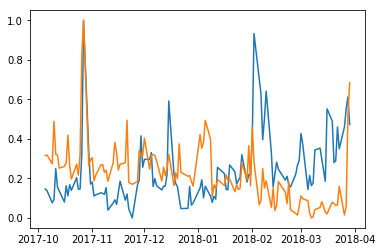

In [67]:
StatVolToTweetVol(data_SA_SP_GOOG)

<u> Stock Volume and Tweet Sentiment </u>
1. <u>Stock Volume impact on Daily Tweet Sentiment:</u> For 0 and 1 lag days, the p-value is **not** significant. However, it is significant in 2 day. This indicates that the stock volume is negatively correlated with tweet sentiment post 2 days. But here also, the correaltion is very low.
2. <u>Daily Tweet Sentiment impact on Stock volume:</u> For all lag days, the p-value is **not** significant

,Lag,Stock Vol to Tweet Senti,Tweet Senti to Stock Vol
0,0 day lag,Corr -0.1215 P-val:0.1862,Corr -0.1215 P-val:0.1862
1,1 day lag,Corr -0.1079 P-val:0.2427,Corr -0.1253 P-val:0.1745
2,2 day lag,Corr -0.2173 P-val:0.0181,Corr -0.1043 P-val:0.2608


None


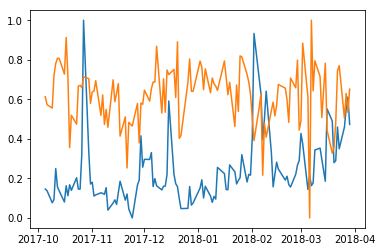

In [68]:
StatVolToTweetSenti(data_SA_SP_GOOG)

#### 4.1.2 Amazon - Volume Bases Analysis

<u> Stock Volume and Tweet Volume</u>
1. <u>Stock Volume impact on Daily Tweet Volume:</u>  on the same day (0 lag) and the next day (1 day lag) p-value is significant and the correlation is high too. This shows that that the increase in stock volume is correlated with the increase in the tweet volume on the same and the next day. However not on the 2 day lag
2. <u>Daily Tweet volume impact on Stock volume:</u> P-val is significant on all the days. This shows the Tweet volume is correlated with the stock volume on the same and coming days (1 and 2 day)

In [24]:
data_SA_SP_AMZN = FinalDataSet('AMZN')

,Lag,Stock Vol to TweetVol,TweetVol to Stock Vol
0,0 day lag,Corr 0.6626 P-val:0.0,Corr 0.6626 P-val:0.0
1,1 day lag,Corr 0.292 P-val:0.0013,Corr 0.5657 P-val:0.0
2,2 day lag,Corr 0.0834 P-val:0.3691,Corr 0.32 P-val:0.0004


None


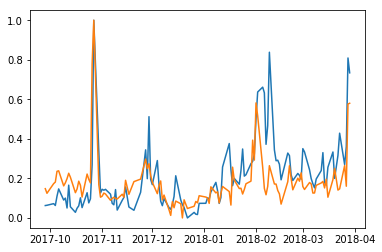

In [69]:
StatVolToTweetVol(data_SA_SP_AMZN)

<u> Stock Volume and Tweet Sentiment </u>
1. <u>Stock Volume impact on Daily Tweet Sentiment:</u> For all lag days, the p-value is significant.The stock volumes is negatively correlated with the stock volume. The increase in stock volume attracts negtive sentiment on twitter
2. <u>Daily Tweet Sentiment impact on Stock volume:</u> For all lag days, the p-value is significant. Negative Twitter sentiment is negatively related to Stock Vol

,Lag,Stock Vol to Tweet Senti,Tweet Senti to Stock Vol
0,0 day lag,Corr -0.4665 P-val:0.0,Corr -0.4665 P-val:0.0
1,1 day lag,Corr -0.3488 P-val:0.0001,Corr -0.4118 P-val:0.0
2,2 day lag,Corr -0.181 P-val:0.0498,Corr -0.349 P-val:0.0001


None


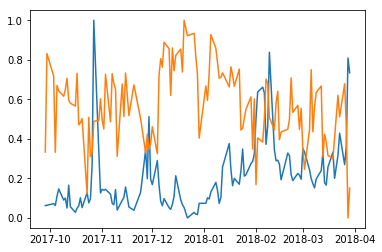

In [70]:
StatVolToTweetSenti(data_SA_SP_AMZN)

#### 4.1.3 Facebook - Volume based Analysis

<u> Stock Volume and Tweet Volume</u>
1. <u>Stock Volume impact on Daily Tweet Volume:</u> For all lag days, the p-value is significant. This shows that stock volume is positively correlated to Tweet volume for facebook.
2. <u>Daily Tweet volume impact on Stock volume:</u> For all lag days, the p-value is significant. This shows that stock volume is positively correlated to Tweet volume for facebook

In [53]:
data_SA_SP_FB = FinalDataSet('FB')

,Lag,Stock Vol to TweetVol,TweetVol to Stock Vol
0,0 day lag,Corr 0.9222 P-val:0.0,Corr 0.9222 P-val:0.0
1,1 day lag,Corr 0.6933 P-val:0.0,Corr 0.6991 P-val:0.0
2,2 day lag,Corr 0.4896 P-val:0.0,Corr 0.521 P-val:0.0


None


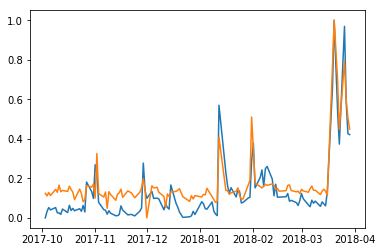

In [79]:
StatVolToTweetVol(data_SA_SP_FB)

<u> Stock Volume and Tweet Sentiment </u>
1. <u>Stock Volume impact on Daily Tweet Sentiment:</u> For all lag days, the p-value is significant.The stock volumes is negatively correlated with the stock volume. The increase in stock volume attracts negtive sentiment on twitter
2. <u>Daily Tweet Sentiment impact on Stock volume:</u> For all lag days, the p-value is significant. Negative Twitter sentiment is negatively related to Stock Vol

,Lag,Stock Vol to Tweet Senti,Tweet Senti to Stock Vol
0,0 day lag,Corr -0.6254 P-val:0.0,Corr -0.6254 P-val:0.0
1,1 day lag,Corr -0.4878 P-val:0.0,Corr -0.5829 P-val:0.0
2,2 day lag,Corr -0.4325 P-val:0.0,Corr -0.3783 P-val:0.0


None


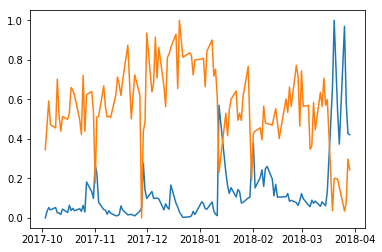

In [72]:
StatVolToTweetSenti(data_SA_SP_FB)

### 4.2 Price Based Analysis
<a id='price'></a>

Price Based based analysis means we are analysing the impact of the daily stock Prices on daily tweet metric. Following analysis is performed for 3 companies **Google**, **Amazon**, **Facebook**:

A quick slice and dice of our analysis:

We are considering the effect of <br> 
1) Stock Close Price and Tweet Sentiment<br> 
2) % Stock Price Change and Tweet Sentiment<br> 

We perform this analysis with different lag days.

**Stock Close Price and Tweet Sentiment**
    - Stock Price to Tweet Volume
        0 day, 1 day and 2 Day
    - Tweet Volume to Stock Price
        0 day, 1 day and 2 Day

** % Stock Price Change and Tweet Sentiment**
    - Stock Price to Tweet Sentiment
        0 day, 1 day and 2 Day
    - Tweet Sentiment to Stock Price
        0 day, 1 day and 2 Day

#### 4.2.1 Google - Price Based Analysis

<u> Stock Close Price and Tweet Sentiment</u>
1. <u>Stock Close Price on Daily Tweet Sentiment:</u> For all lag days, the p-value is **not** significant.
2. <u>Daily Tweet Sentiment impact on Stock Close Price:</u> For all lag days, the p-value is **not** significant.

,Lag,Close Price to Sentiment,Sentiment to Close Price
0,1 day lag,Corr -0.0092 P-val:0.921,Corr 0.1269 P-val:0.1692
1,2 day lag,Corr -0.0354 P-val:0.7032,Corr 0.1109 P-val:0.2318
2,3 day lag,Corr -0.0969 P-val:0.2986,Corr 0.1147 P-val:0.2183


None


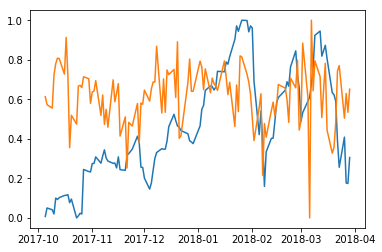

In [80]:
StatCloseToMood(data_SA_SP_GOOG)

<u> Stock price change percent and Tweet Sentiment </u>
1. <u>Stock price change percent on Daily Tweet Sentiment:</u> For the same day p-value is not significant. However for 1 and 2 day lag, the p-value is significant. But the correlation is very low.
2. <u>Daily Tweet Sentiment impact on Stock price change percent:</u> For all lag days, the p-value is significant.However, correlation is very low.

,Lag,Cent Change to Sentiment,Sentiment to Cent Change
0,1 day lag,Corr 0.0755 P-val:0.4143,Corr 0.1931 P-val:0.0354
1,2 day lag,Corr 0.1831 P-val:0.0472,Corr 0.1831 P-val:0.0472
2,3 day lag,Corr 0.1954 P-val:0.0348,Corr 0.1954 P-val:0.0348


None


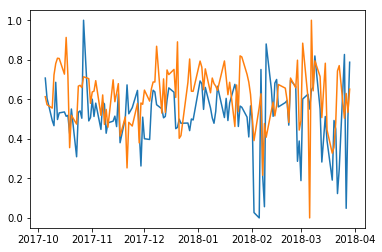

In [81]:
#### cent_change to mood
StatCentChangeToMood(data_SA_SP_GOOG)

#### 4.2.2 Amazon - Price Based Analysis

<u> Stock Close Price and Tweet Sentiment</u>
1. <u>Stock Close Price on Daily Tweet Sentiment:</u> For all lag days, the p-value is significant. Correlation is negative. This means the close price negatively impacts sentiment. The value is still small.
2. <u>Daily Tweet Sentiment impact on Stock Close Price:</u> For all lag days, the p-value is significant. Correlation is negative and small.

,Lag,Close Price to Sentiment,Sentiment to Close Price
0,1 day lag,Corr -0.2601 P-val:0.0043,Corr -0.2177 P-val:0.0174
1,2 day lag,Corr -0.2626 P-val:0.0041,Corr -0.1994 P-val:0.0304
2,3 day lag,Corr -0.2562 P-val:0.0053,Corr -0.1886 P-val:0.0417


None


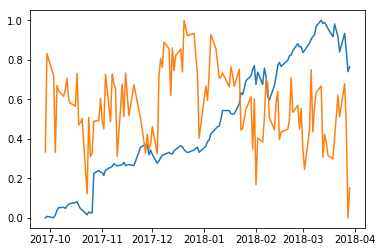

In [75]:
StatCloseToMood(data_SA_SP_AMZN)

<u> Stock price change percent and Tweet Sentiment </u>
1. <u>Stock price change percent on Daily Tweet Sentiment:</u> For all p-val is **not** significant.
2. <u>Daily Tweet Sentiment impact on Stock price change percent:</u> For all p-val is **not** significant.

,Lag,Cent Change to Sentiment,Sentiment to Cent Change
0,1 day lag,Corr 0.1324 P-val:0.1511,Corr -0.1116 P-val:0.227
1,2 day lag,Corr 0.0408 P-val:0.6608,Corr 0.0408 P-val:0.6608
2,3 day lag,Corr 0.0046 P-val:0.9605,Corr 0.0046 P-val:0.9605


None


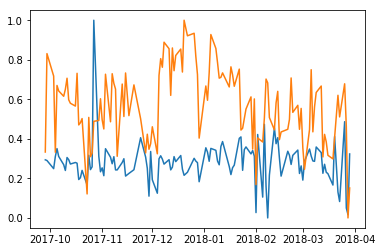

In [82]:
StatCentChangeToMood(data_SA_SP_AMZN)

#### 4.2.3 Facebook - Price Based Analysis

<u> Stock Close Price and Tweet Sentiment</u>
1. <u>Stock Close Price on Daily Tweet Sentiment:</u> For only 0 lag, the p-val is significant. However the correlation is small.
2. <u>Daily Tweet Sentiment Impact on Stock Close Price:</u> For all lag days, the p-value is significant. Correlation value is significant too. This means that the sentiment is positively related to stock close price.

,Lag,Close Price to Sentiment,Sentiment to Close Price
0,1 day lag,Corr 0.2512 P-val:0.0059,Corr 0.4194 P-val:0.0
1,2 day lag,Corr 0.1303 P-val:0.1597,Corr 0.4282 P-val:0.0
2,3 day lag,Corr 0.0738 P-val:0.4293,Corr 0.3928 P-val:0.0


None


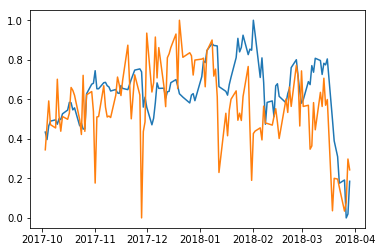

In [77]:
StatCloseToMood(data_SA_SP_FB)

<u> Stock price change percent and Tweet Sentiment </u>
1. <u>Stock price change percent on Daily Tweet Sentiment:</u> For only 0 lag, the p-val is significant. However the correlation is small.
2. <u>Daily Tweet Sentiment impact on Stock price change percent:</u> For all p-val is **not** significant.

,Lag,Cent Change to Sentiment,Sentiment to Cent Change
0,1 day lag,Corr 0.2709 P-val:0.0029,Corr 0.1715 P-val:0.0622
1,2 day lag,Corr 0.1427 P-val:0.1233,Corr 0.1427 P-val:0.1233
2,3 day lag,Corr 0.1509 P-val:0.1043,Corr 0.1509 P-val:0.1043


None


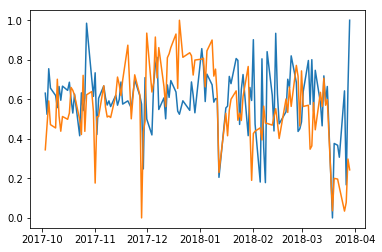

In [78]:
StatCentChangeToMood(data_SA_SP_FB)

## 5 Sentiment Analysis
<a id='senti'></a>

Sentiment Analysis is performed on each day tweet to find the writter's attitude expressed in the text. We are using python package - Textblob. The function return value called polarity between -1 and 1. 1 being most positive sentiment and -1 being the most negative sentiment.

In [65]:
def clean_text(text):
    '''
    Utility function to clean the text in a comment by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

def analize_sentiment(text):
    '''
    Utility function to classify the polarity of a comment
    using textblob.
    '''
    analysis = TextBlob(clean_text(text))
    return(analysis.sentiment.polarity)

In [ ]:
#GOOG
data_frame = pd.read_csv('Data/GOOGTweets.csv', encoding = "ISO-8859-1")
data_frame['clean_text'] = np.array([ clean_text(text) for text in data_frame['full_text'].astype(str)])
data_frame['SA'] = np.array([ analize_sentiment(text) for text in data_frame['clean_text']])
data_frame.to_csv('Data/GOOGTweets_senti.csv')

In [ ]:
#AMZN
data_frame = pd.read_csv('Data/AMZNTweets.csv', encoding = "ISO-8859-1")
data_frame['clean_text'] = np.array([ clean_text(text) for text in data_frame['full_text'].astype(str)])
data_frame['SA'] = np.array([ analize_sentiment(text) for text in data_frame['clean_text']])
data_frame.to_csv('Data/AMZNTweets_senti.csv')

In [ ]:
#FB
data_frame = pd.read_csv('Data/FBTweets.csv', encoding = "ISO-8859-1")
data_frame['clean_text'] = np.array([ clean_text(text) for text in data_frame['full_text'].astype(str)])
data_frame['SA'] = np.array([ analize_sentiment(text) for text in data_frame['clean_text']])
data_frame.to_csv('Data/FBTweets_senti.csv')

## 6 Conclusion
<a id='end'></a>

Before the start of this project , we anticipated that an increase in discussions over Twitter(Average total number of tweets) would encourage the daily trading of shares on the stock market, based on the premise that emotional arousal leads to action. From our analysis, we conclude that usage of twitter metrics as features in predicting Stock price is not advisable, because the correlation between them are not consistent across different hypothesis tested out in our experiments.

## 7 Data Collection
<a id='collect'></a>
We have done scrapping from 2 sources for two different datasets:

1. Twitter
2. Yahoo Finance 

Both are described below in details

### 7.1 Data Scrape from Twitter
<a id='twitter'></a>

**We have taken following 3 steps for Data Collection:** <br>

1) Get Tweets Id from Scrapping the financial data for 5 companies -  Amazon, Facebook, Google <br>
    
2) Get the Twitter Text using below 5 commands. The resultant is 5 json file. <br>

twarc hydrate AMZNTweets.txt > AMZNTweets.json <br>
twarc hydrate FBTweets.txt > FBTweets.json <br>
twarc hydrate GOOGTweets.txt > GOOGTweets.json <br>


3) Json file are then converted into CSV

#### Google

In [ ]:
#Get 2018 Data - Google Tweets
if __name__ == '__main__':
    # print the retrieved tweets to the screen:
    
    #Enter Start Date ------------- here 
    start_date = dt.date(2016,1,1)
    end_date = start_date + dt.timedelta(days = 30)
    
    #Enter end Date ------------- here 
    final_end_date = dt.date(2018,3,31)
    
    file = open('Data/GOOGTweets.txt','w') 
    while end_date < final_end_date:
        print(start_date, end_date)
        for tweet in query_tweets("$GOOG", begindate = start_date, enddate = final_end_date):
            file.write(tweet.id+'\n')
        start_date = end_date + dt.timedelta(days = 1)
        end_date = end_date + dt.timedelta(days = 30)
    
    file.close()
    #For remaing Days
    file = open('Data/GOOGTweets.txt','a+') 
    print(start_date, final_end_date)
    for tweet in query_tweets("$GOOG", begindate = start_date, enddate = final_end_date):
        file.write(tweet.id+'\n')

    file.close()
    print('Done')

#### Amazon

In [ ]:
#Get 2018 Data - Amazon Tweets
if __name__ == '__main__':
    # print the retrieved tweets to the screen:
    
    #Enter Start Date ------------- here 
    start_date = dt.date(2016,1,1)
    end_date = start_date + dt.timedelta(days = 30)
    
    #Enter end Date ------------- here 
    final_end_date = dt.date(2018,3,31)
    
    file = open('Data/AMZNTweets.txt','w') 
    while end_date < final_end_date:
        print(start_date, end_date)
        for tweet in query_tweets("$AMZN", begindate = start_date, enddate = end_date):
            file.write(tweet.id+'\n')
        start_date = end_date + dt.timedelta(days = 1)
        end_date = end_date + dt.timedelta(days = 30)
    
    file.close()
    #For remaing Days
    file = open('Data/AMZNTweets.txt','a+') 
    print(start_date, final_end_date)
    for tweet in query_tweets("$AMZN", begindate = start_date, enddate = final_end_date):
        file.write(tweet.id+'\n')

    file.close()
    print('Done')

#### Facebook

In [ ]:
#Get 2018 Data - Facebook Tweets
if __name__ == '__main__':
    # print the retrieved tweets to the screen:
    
    #Enter Start Date ------------- here 
    start_date = dt.date(2016,1,1)
    end_date = start_date + dt.timedelta(days = 30)
    
    #Enter end Date ------------- here 
    final_end_date = dt.date(2018,3,31)
    
    file = open('Data/FBTweets.txt','w') 
    while end_date < final_end_date:
        print(start_date, end_date)
        for tweet in query_tweets("$FB", begindate = start_date, enddate = end_date):
            file.write(tweet.id+'\n')
        start_date = end_date + dt.timedelta(days = 1)
        end_date = end_date + dt.timedelta(days = 30)
    
    file.close()
    #For remaing Days
    file = open('Data/FBTweets.txt','a+') 
    print(start_date, final_end_date)
    for tweet in query_tweets("$FB", begindate = start_date, enddate = final_end_date):
        file.write(tweet.id+'\n')

    file.close()
    print('Done')

### Data from Json to CSV

#### Google

In [ ]:
#Google
GOOG = pd.DataFrame(index = range(612000),columns = ['created_at','full_text'])

count = 0
with open('Data/GOOGTweets.json') as f:
    content = f.readlines()
    for x in content:
        d = json.loads(x)
        GOOG.loc[count].created_at = d['created_at']
        GOOG.loc[count].full_text = d['full_text']
        count = count + 1
GOOG.dropna(inplace=True)

#Replacing special characters spliting full_text into lines
GOOG = GOOG.replace({'full_text': {r'\r': ''}}, regex=True)
GOOG = GOOG.replace({'full_text': {r'\r\r': ''}}, regex=True)
GOOG = GOOG.replace({'full_text': {r'\r\n': ''}}, regex=True)
GOOG = GOOG.replace({'full_text': {r'\n': ''}}, regex=True)

#Date Formatting
b = GOOG.created_at.str[4:19] + ' ' + GOOG.created_at.str[26:30]
GOOG['tweet_date'] = pd.to_datetime(b, format='%b %d %H:%M:%S %Y')

#Convert dataframe to csv
GOOG.to_csv('Data/GOOGTweets.csv')

#### Amazon

In [ ]:
#Amazon
AMZN = pd.DataFrame(index = range(500000),columns = ['created_at','full_text'])

count = 0
with open('Data/AMZNTweets.json') as f:
    content = f.readlines()
    for x in content:
        d = json.loads(x)
        AMZN.loc[count].created_at = d['created_at']
        AMZN.loc[count].full_text = d['full_text']
        count = count + 1
AMZN.dropna(inplace=True)

#Replacing special characters spliting full_text into lines
AMZN = AMZN.replace({'full_text': {r'\r': ''}}, regex=True)
AMZN = AMZN.replace({'full_text': {r'\r\r': ''}}, regex=True)
AMZN = AMZN.replace({'full_text': {r'\r\n': ''}}, regex=True)
AMZN = AMZN.replace({'full_text': {r'\n': ''}}, regex=True)

#Date Formatting
b = AMZN.created_at.str[4:19] + ' ' + AMZN.created_at.str[26:30]
AMZN['tweet_date'] = pd.to_datetime(b, format='%b %d %H:%M:%S %Y')

#Convert dataframe to csv
AMZN.to_csv('Data/AMZNTweets.csv')

#### Facebook

In [ ]:
#Facebook
FB = pd.DataFrame(index = range(640000),columns = ['created_at','full_text'])

count = 0
with open('Data/FBTweets.json') as f:
    content = f.readlines()
    for x in content:
        d = json.loads(x)
        FB.loc[count].created_at = d['created_at']
        FB.loc[count].full_text = d['full_text']
        count = count + 1
FB.dropna(inplace=True)

#Replacing special characters spliting full_text into lines
FB = FB.replace({'full_text': {r'\r': ''}}, regex=True)
FB = FB.replace({'full_text': {r'\r\r': ''}}, regex=True)
FB = FB.replace({'full_text': {r'\r\n': ''}}, regex=True)
FB = FB.replace({'full_text': {r'\n': ''}}, regex=True)

#Date Formatting
b = FB.created_at.str[4:19] + ' ' + FB.created_at.str[26:30]
FB['tweet_date'] = pd.to_datetime(b, format='%b %d %H:%M:%S %Y')

#Convert dataframe to csv
FB.to_csv('Data/FBTweets.csv')

### 7.2 Data Scrape from Yahoo Finance
<a id='finance'></a>

The code below scrapes stock prices of the companies from Yahoo Finance page

In [ ]:
import requests
import re
import pandas as pd
from datetime import datetime, timedelta
from io import StringIO


class GetData:
    
    cr_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    cr_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'
    time_out = 2
    
    
    def __init__(self, sym, string_date_from,string_date_to):
        self.sym = sym
        self.string_date_from = string_date_from
        self.string_date_to = string_date_to
        self.session = requests.Session()

    def get_crumb(self):
        resp = self.session.get(self.cr_link.format(self.sym), timeout=self.time_out)
        resp.raise_for_status()
        match = re.search(self.cr_regex, resp.text)
        if not match:
            raise ValueError('Failed to get crumb')
        else:
            self.crumb = match.group(1)

    def get_price(self):
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        dt1 = datetime.strptime(self.string_date_to, "%Y-%m-%d %H:%M:%S.%f")
        dateto = int(dt1.timestamp())
        dt2 = datetime.strptime(self.string_date_from, "%Y-%m-%d %H:%M:%S.%f")
        datefrom = int(dt2.timestamp())
        url = self.quote_link.format(quote=self.sym, dfrom=datefrom, dto=dateto, crumb=self.crumb)
        resp = self.session.get(url)
        resp.raise_for_status()
        return pd.read_csv(StringIO(resp.text), parse_dates=['Date'])
    
df_goog = GetData('GOOG',string_date_from = '2016-01-01 10:00:00.313648' ,string_date_to = '2018-03-31 10:00:00.313648' ).get_price()
df_goog.to_csv('GOOG.csv')

df_fb = GetData('FB',string_date_from = '2016-01-01 10:00:00.313648' ,string_date_to = '2018-03-31 10:00:00.313648' ).get_price()
df_fb.to_csv('FB.csv')

df_amzn = GetData('AMZN',string_date_from = '2016-01-01 10:00:00.313648' ,string_date_to = '2018-03-31 10:00:00.313648' ).get_price()
df_amzn.to_csv('AMZN.csv')



## 8 References
<a id='ref'></a>

1) http://www.businessdictionary.com/definition/hypothesis-testing.html <br>
2) https://www.sciencedirect.com/science/article/pii/S2405918817300247